<a href="https://colab.research.google.com/github/SHINDongHyeo/Increase-Resolution-project/blob/main/SRCNN%EC%8B%A4%EC%8A%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고한 블로그 : https://panggu15.github.io/gan/SRCNN/

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SuperResolutionProject

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/SuperResolutionProject


In [2]:
import torch
import torch.optim as optim
import torch.nn as nn
from torchvision.transforms import ToPILImage
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
import time
from torchvision.utils import save_image

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
print(device)

cuda


In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob

train_path = sorted(glob.glob('/content/drive/MyDrive/SuperResolutionProject/images/train/*.jpg'))
val_path = sorted(glob.glob('/content/drive/MyDrive/SuperResolutionProject/images/val/*.jpg'))
print(len(train_path), len(val_path))

5502 178


In [5]:
class SRdataset(Dataset):

    def __init__(self, paths):
        self.paths = paths        

    def __len__(self):
        return len(self.paths)

    def __getitem__(self,idx):
        path = self.paths[idx]

        img = cv2.imread(path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, dsize=(40, 40), interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        inp = cv2.GaussianBlur(img,(0,0),1)
        img = np.transpose(img, (2,0,1)) # 정상 이미지
        inp = np.transpose(inp, (2,0,1)) # 가우시안 블러로 흐릿하게 만든 이미지

        input_sample, label_sample = torch.tensor(inp, dtype=torch.float32), torch.tensor(img, dtype=torch.float32)

        return input_sample,label_sample # 즉, 가우시안 블러로 흐릿하게 만든 이미지가 들어와도 원래 정상 이미지를 유추할 수 있도록 두 이미지를 넣어줄 것이라는 것을 알 수 있다

In [6]:
train_ds = SRdataset(train_path)
train_dl = DataLoader(train_ds, batch_size=64)
val_ds = SRdataset(val_path)
val_dl = DataLoader(val_ds, batch_size=64)

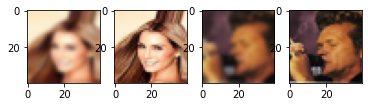

In [7]:
for image, label in train_dl:
  img = image[0]
  lab = label[0]
  break
for image, label in val_dl:
  img2 = image[0]
  lab2 = label[0]
  break

plt.subplot(1,4,1)
plt.imshow(np.transpose(img, (1,2,0)))
plt.subplot(1,4,2)
plt.imshow(np.transpose(lab, (1,2,0)))
plt.subplot(1,4,3)
plt.imshow(np.transpose(img2, (1,2,0)))
plt.subplot(1,4,4)
plt.imshow(np.transpose(lab2, (1,2,0)))

In [8]:
class SRCNN(nn.Module):
    def __init__(self):
        super().__init__()

        # padding_mode='replicate'는 zero padding이 아닌, 주변 값을 복사해서 padding 합니다.
        self.conv1 = nn.Conv2d(3, 64, 9, padding=2, padding_mode='replicate')
        self.conv2 = nn.Conv2d(64, 32, 1, padding=2, padding_mode='replicate')
        self.conv3 = nn.Conv2d(32, 3, 5, padding=2, padding_mode='replicate')

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.conv3(x)

        return x

In [9]:
# 가중치 초기화
def initialize_weights(model):
    classname = model.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)

model = SRCNN().to(device)
model.apply(initialize_weights);

In [10]:
# 손실함수
loss_func = nn.MSELoss()

optimizer = optim.Adam(model.parameters())

In [11]:
import math

# PSNR function: 모델의 출력값과 high-resoultion의 유사도를 측정합니다.
# PSNR 값이 클수록 좋습니다.
def psnr(label, outputs, max_val=1.):
    label = label.cpu().detach().numpy()
    outputs = outputs.cpu().detach().numpy()
    img_diff = outputs - label
    rmse = math.sqrt(np.mean((img_diff)**2))
    if rmse == 0: # label과 output이 완전히 일치하는 경우
        return 100
    else:
        psnr = 20 * math.log10(max_val/rmse)
        return psnr

In [12]:
# train 함수
def train(model, data_dl):
    model.train()
    running_loss = 0.0
    running_psnr = 0.0
    print("data_dl의 길이 : ",len(data_dl))
    for i, (image, label) in enumerate(data_dl):
        print(f"{i}번째 train")
        a = time.time()
        image = image.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        outputs = model(image)
        loss = loss_func(outputs, label)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        batch_psnr = psnr(label, outputs)
        running_psnr += batch_psnr

        b= time.time()
        print(f"{b-a:.2f} sec")
    
    final_loss = running_loss / len(data_dl.dataset)
    final_psnr = running_psnr / int(len(train_ds)/data_dl.batch_size)
    return final_loss, final_psnr


# validation 함수
def validate(model, data_dl, epoch):
    # epoch는 이미지를 저장할때, 이미지의 이름으로 사용됩니다.
    
    model.eval()
    running_loss = 0.0
    running_psnr = 0.0
    with torch.no_grad():
        for ba, data in enumerate(data_dl):
            print(f"{ba}번째 val")
            c = time.time()
            image = data[0].to(device)
            label = data[1].to(device)

            outputs = model(image)
            loss = loss_func(outputs, label)

            running_loss += loss.item()
            batch_psnr = psnr(label,outputs)
            running_psnr += batch_psnr

            d= time.time()
            print(f"{d-c:.2f} sec")

        outputs = outputs.cpu()
        # tensor를 입력받아 이미지 파일로 저장합니다.
        save_image(outputs, f'/content/drive/MyDrive/SuperResolutionProject/images/val_output/{epoch}.png')
    
    final_loss = running_loss / len(data_dl.dataset)
    final_psnr = running_psnr / int(len(val_ds)/data_dl.batch_size)
    return final_loss, final_psnr

In [13]:
num_epochs = 100

# 학습하기
train_loss, val_loss = [], []
train_psnr, val_psnr = [], []
start = time.time()
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1} of {num_epochs}')
    train_epoch_loss, train_epoch_psnr = train(model, train_dl)
    val_epoch_loss, val_epoch_psnr = validate(model, val_dl, epoch)

    train_loss.append(train_epoch_loss)
    train_psnr.append(train_epoch_psnr)
    val_loss.append(val_epoch_loss)
    val_psnr.append(val_epoch_psnr)
    end = time.time()
    print(f'Train PSNR: {train_epoch_psnr:.3f}, Val PSNR: {val_epoch_psnr:.3f}, Time: {end-start:.2f} sec')
    
# 학습된 모델 저장하기
torch.save(model, "MyTrainModel.pt")

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
33번째 train
0.02 sec
34번째 train
0.01 sec
35번째 train
0.02 sec
36번째 train
0.02 sec
37번째 train
0.02 sec
38번째 train
0.01 sec
39번째 train
0.02 sec
40번째 train
0.02 sec
41번째 train
0.01 sec
42번째 train
0.01 sec
43번째 train
0.01 sec
44번째 train
0.01 sec
45번째 train
0.01 sec
46번째 train
0.01 sec
47번째 train
0.01 sec
48번째 train
0.02 sec
49번째 train
0.01 sec
50번째 train
0.02 sec
51번째 train
0.02 sec
52번째 train
0.02 sec
53번째 train
0.02 sec
54번째 train
0.01 sec
55번째 train
0.01 sec
56번째 train
0.02 sec
57번째 train
0.01 sec
58번째 train
0.02 sec
59번째 train
0.01 sec
60번째 train
0.01 sec
61번째 train
0.02 sec
62번째 train
0.02 sec
63번째 train
0.02 sec
64번째 train
0.02 sec
65번째 train
0.02 sec
66번째 train
0.01 sec
67번째 train
0.01 sec
68번째 train
0.02 sec
69번째 train
0.01 sec
70번째 train
0.01 sec
71번째 train
0.01 sec
72번째 train
0.01 sec
73번째 train
0.01 sec
74번째 train
0.02 sec
75번째 train
0.01 sec
76번째 train
0.02 sec
77번째 train
0.01 sec
78번째 train
0.02 sec
79번째 train
0.02 sec
80번째 train
0.02 sec
81번째

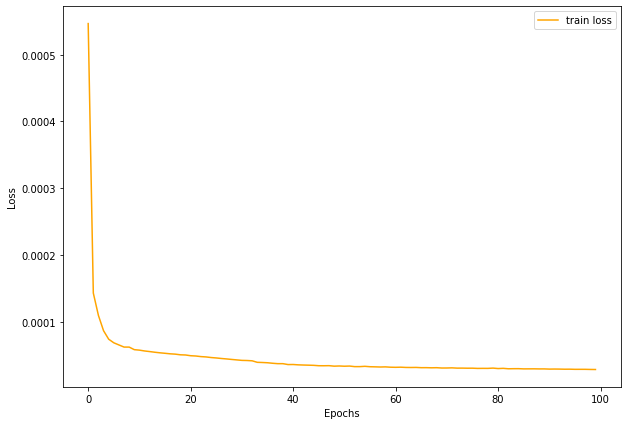

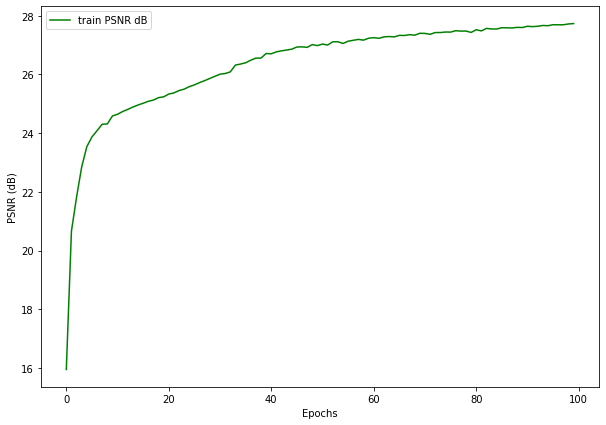

In [14]:
# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# psnr plots
plt.figure(figsize=(10, 7))
plt.plot(train_psnr, color='green', label='train PSNR dB')
plt.xlabel('Epochs')
plt.ylabel('PSNR (dB)')
plt.legend()
plt.show()

In [15]:
for img, label in train_dl:
    img = img[0]
    label = label[0]
    break

# super-resolution
model.eval()
with torch.no_grad():
    img_ = img.unsqueeze(0)
    img_ = img_.to(device)
    output = model(img_)
    output = output.squeeze(0)

# 결과확인
저화질 이미지, 학습된 모델로 유추한 이미지, 고화질 이미지를 순서대로 확인해본다.

Text(0.5, 1.0, 'origingal')

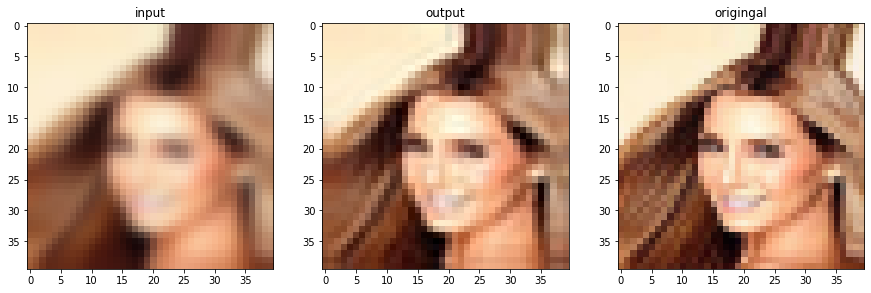

In [16]:
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.imshow(np.transpose(img, (1,2,0)))
plt.title('input')
plt.subplot(1,3,2)
plt.imshow(np.transpose(output.cpu(), (1,2,0)))
plt.title('output')
plt.subplot(1,3,3)
plt.imshow(np.transpose(label, (1,2,0)))
plt.title('origingal')